<a href="https://colab.research.google.com/github/guptavaishnavi536/iris_recognition/blob/main/IRIS_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:** Vaishnavi Gupta<br>
**Program:** MBATech CS<br>
**Roll Number:** N019<br>
**Date of performance and submission:** 10/02/2023<br>


---



# **Aim:** The aim of the experiment is to study and understand the theory of and implement an Iris Recognition System

# **Approach 1**

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np


In [ ]:
import cv2
import numpy as np
import itertools
import math
from typing import Tuple, List


def daugman(gray_img: np.ndarray, center: Tuple[int, int],
            start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
    """ The function will calculate pixel intensities for the circles
        in the ``range(start_r, end_r, step)`` for a given ``center``,
        and find a circle that precedes the biggest intensity drop
        :param gray_img: grayscale picture
        :param center:  center coordinates ``(x, y)``
        :param start_r: bottom value for iris radius in pixels
        :param end_r: top value for iris radius in pixels
        :param step: step value for iris radii range in pixels
        .. attention::
            Input grayscale image should be a square, not a rectangle
        :return: intensity_value, radius
    """
    x, y = center
    intensities = []
    mask = np.zeros_like(gray_img)

    # for every radius in range
    radii = list(range(start_r, end_r, step))  # type: List[int]
    for r in radii:
        # draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # get pixel from original image, it is faster than np or cv2
        diff = gray_img & mask
        # normalize, np.add.reduce faster than .sum()
        #            diff[diff > 0] faster than .flatten()
        intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
        # refresh mask
        mask.fill(0)

    # calculate delta of radius intensitiveness
    #     mypy does not tolerate var type reload
    intensities_np = np.array(intensities, dtype=np.float32)
    del intensities

    # circles intensity differences, x5 faster than np.diff()
    intensities_np = intensities_np[:-1] - intensities_np[1:]
    # aply gaussian filter
    #     GaussianBlur() faster than filter2D() with custom kernel
    # original kernel:
    # > The Gaussian filter in our case is designedin MATLAB and
    # > is a 1 by 5 (rows by columns) vector with intensity values
    # > given by vector A = [0.0003 0.1065 0.7866 0.1065 0.0003]
    intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))
    # get maximum value
    idx = np.argmax(intensities_np)  # type: int

    # return intensity value, radius
    return intensities_np[idx], radii[idx]


def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 1,) -> Tuple[Tuple[int, int], int]:
    """ The function will apply :func:`daugman` on every pixel in the calculated image slice.
        Basically, we are calculating where lies set of valid circle centers.
        It is assumed that iris center lies within central 1/3 of the image.
        :param gray: graysacale **square** image
        :param points_step: it will run daugman for each ``points_step``th point.
                            It has linear correlation with overall iris search speed
        :param daugman_start: bottom value for iris radius in pixels for :func:``daugman``
        :param daugman_end: top value for iris radius in pixels for :func:``daugman``
        :param daugman_step: step value for iris radii range in pixels for :func:``daugman``.
                             It has linear correlation with overall iris search speed
        :return: radius with biggest intensiveness delta on image as ``((xc, yc), radius)``
    """
    h, w = gray.shape
    if h != w:
        print('Your image is not a square!')

    # reduce step for better accuracy
    # we will look only on dots within central 1/3 of image
    single_axis_range = range(int(h / 3), h - int(h / 3), points_step)
    all_points = itertools.product(single_axis_range, single_axis_range)

    intensity_values = []
    coords = []  # List[Tuple[Tuple(int, int), int]]

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    # return the radius with biggest intensiveness delta on image
    # ((xc, yc), radius)
    # x10 faster than coords[np.argmax(values)]
    best_idx = intensity_values.index(max(intensity_values))
    return coords[best_idx]

In [ ]:
""" Code for `daugman_visual_explanation.ipynb`
"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

# from daugman import daugman
# from daugman import find_iris

from typing import List, Tuple, Iterable


class DaugmanVisualExplanation:
    def __init__(self, img_path: str, start_r=10, end_r=30, circle_step=2, points_step=3):
        self.img = self._get_new_image(img_path)
        self.start_r = start_r
        self.end_r = end_r
        self.circle_step = circle_step
        self.points_step = points_step
        self.all_points = self._get_all_potential_iris_centers(self.img)
        self.colors = self._get_unique_color_for_each_point(self.all_points)

    def _get_new_image(self, img_path, gray=False) -> np.ndarray:
        """ Get properly cropped BGR image, which looks like grayscale
        """
        img = cv2.imread(img_path)
        img = img[20:130, 20:130]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if not gray:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img

    def _get_all_potential_iris_centers(self, img: np.ndarray) -> List[Tuple[int, int]]:
        # get all potential points for search (from `find_iris()`)
        h = img.shape[0]
        # we will look only on dots within central 1/3 of image
        single_axis_range = range(int(h / 3), h - int(h / 3), self.points_step)
        all_points = list(itertools.product(single_axis_range, single_axis_range))
        return all_points

    def _get_unique_color_for_each_point(self, all_points: List[Tuple[int, int]]) -> List[Tuple[int, int, int]]:
        colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for i in self.all_points]
        return colors

    def plot_all_potential_iris_centers(self) -> np.ndarray:
        # plot all potential points
        img_dot = self.img.copy()
        for point, color in zip(self.all_points, self.colors):
            cv2.circle(img_dot, point, 0, color, -1)

        _ = plt.imshow(img_dot[::, ::, ::-1])
        return img_dot

    def plot_circles_for_one_center(self, img_dot: np.ndarray, dot_idx=0) -> np.ndarray:
        img_circles = img_dot.copy()

        # within circles in radii range from 10px to 1/4 of image side

        # plot the chosen potential point
        cv2.circle(img_circles, list(self.all_points)[dot_idx], 0, self.colors[dot_idx], 1)
        # plot all circle candidates for the single potential point
        img_circles = self._draw_circles(img_circles, self.all_points[dot_idx], self.colors[dot_idx],
                                         start_r=self.start_r, end_r=self.end_r, step=self.circle_step)

        _ = plt.imshow(img_circles[::, ::, ::-1])
        return img_circles

    def _draw_circles(self, img: np.ndarray,
                      center: Tuple[int, int], color: Tuple[int, int, int],
                      start_r: int, end_r: int, step: int,
                      alpha=0.5) -> np.ndarray:
        """ Part of ``daugman()`` modified for presentation purposes
        """
        # get separate coordinates
        x, y = center
        overlay = img.copy()

        radii = list(range(start_r, end_r, step))
        for r in radii:
            cv2.circle(overlay, center, r, color, 1)

        img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
        return img

    def plot_best_circle_for_single_potential_iris_center(self, img_dot: np.ndarray,
                                                          dot_idx: int, color=None, alpha=0.8) -> np.ndarray:
        gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        # get best circle
        _, best_radius = daugman(gray_img, self.all_points[dot_idx],
                                 self.start_r, self.end_r, self.circle_step)
        # plot best circle
        if not color:
            color = self.colors[dot_idx]

        overlay = img_dot.copy()
        cv2.circle(overlay, self.all_points[dot_idx], best_radius, color, 1)
        img_dot = cv2.addWeighted(overlay, alpha, img_dot, 1 - alpha, 0)
        return img_dot

    def plot_best_circle_for_a_few_potential_iris_centers(self, img_dot: np.ndarray,
                                                          idxs: Iterable[int]) -> np.ndarray:
        img = img_dot.copy()

        for idx in idxs:
            img = self.plot_best_circle_for_single_potential_iris_center(img, idx)

        _ = plt.imshow(img[::, ::, ::-1])
        return img_dot

    def find_iris(self, *, daugman_start, daugman_end, daugman_step, points_step) -> np.ndarray:
        gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        answer = find_iris(gray_img, daugman_start=daugman_start, daugman_end=daugman_end,
                           daugman_step=daugman_step, points_step=points_step)
        iris_center, iris_rad = answer
        out = self.img.copy()
        cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
        _ = plt.imshow(out[::, ::, ::-1])
        return out

    def plot_pixel_intensity_delta_pic(self) -> None:
        # white image
        img = np.full([100, 100, 3], 255, dtype=np.uint8)
        # black circle
        img = cv2.circle(img, (50, 50), 20, [0, 0, 0], -1)
        # yellow
        img = cv2.circle(img, (50, 50), 10, [255, 255, 0], 1)
        # green
        img = cv2.circle(img, (50, 50), 15, [0, 255, 0], 1)
        # red
        img = cv2.circle(img, (50, 50), 20, [255, 0, 0], 1)
        # blue
        img = cv2.circle(img, (50, 50), 25, [0, 0, 255], 1)
        _ = plt.imshow(img)

    def find_iris_on_binary_image(self, *, daugman_start, daugman_end, daugman_step, points_step) -> None:
        # create simple image
        img = np.full([100, 100, 3], 255, dtype=np.uint8)
        img = cv2.circle(img, (50, 50), 20, [0, 0, 0], -1)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        answer = find_iris(gray_img, daugman_start=daugman_start, daugman_end=daugman_end,
                           daugman_step=daugman_step, points_step=points_step)
        iris_center, iris_rad = answer
        cv2.circle(img, iris_center, iris_rad, (0, 0, 255), 1)
        _ = plt.imshow(img[::, ::, ::-1])

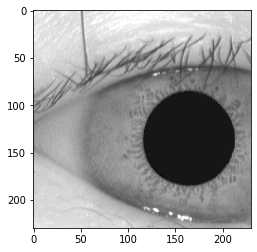

In [ ]:
# read, square crop and grayscale image of an eye
img = cv2.imread('/content/CASIA-Iris-Image-Database-Sample-Images.png')
img = img[20:250, 20:250]
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_ = plt.imshow(gray_img, cmap='gray')

In [ ]:
# minimal iris radius -- 10px
# maximal iris radius -- 30px
answer = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=3)
print(answer)

iris_center, iris_rad = answer

((133, 76), 10)


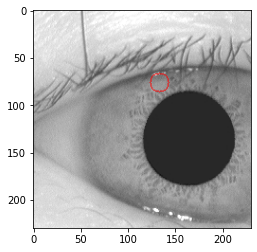

In [ ]:
# plot result
out = img.copy()
cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
_ = plt.imshow(out[::,::,::-1])

In [ ]:
%%timeit
find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=3)

461 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# **Approach 2**

Text(0.5, 1.0, 'color iris')

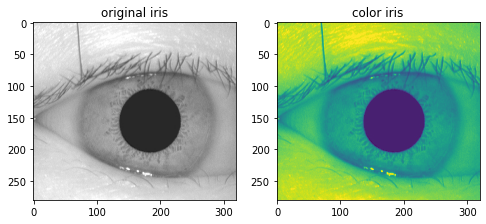

In [ ]:
import cv2
img_1 = cv2.imread('CASIA-Iris-Image-Database-Sample-Images.png')
import numpy as np
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.spatial import distance
col_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
fig,axes = plt.subplots(1,2,figsize = (8,4))
ax = axes.ravel() #converts into 1 dimensional array
ax[0].imshow(img_1)
ax[0].set_title("original iris")
ax[1].imshow(col_img_1)
ax[1].set_title("color iris")


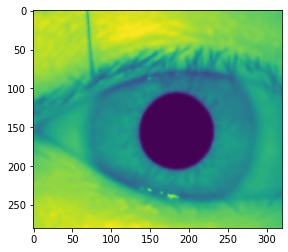

In [ ]:
#IRIS localization

blur_img_1 = cv2.bilateralFilter(col_img_1, 9,75,75)
plt.imshow(blur_img_1)


In [ ]:
#estimate the center of pupil
horizontalProjection = np.mean(blur_img_1,0);
verticalProjection = np.mean(blur_img_1,1);
center_x=horizontalProjection.argmin()
center_y=verticalProjection.argmin()
#recalculate of pupil by concentrating on a 120X120 area
centrecrop_x = blur_img_1[center_x-60:center_x+60]
centrecrop_y = blur_img_1[center_y-60:center_y+60]
horizontalProjection = np.mean(centrecrop_y,0);
verticalProjection = np.mean(centrecrop_x,0);
crop_center_x=horizontalProjection.argmin()
crop_center_y=verticalProjection.argmin()
cimg=blur_img_1.copy()
cv2.circle(cimg,(crop_center_x,crop_center_y),1,(255,0,0),2)


array([[225, 224, 223, ..., 194, 194, 194],
       [224, 224, 223, ..., 194, 194, 194],
       [223, 224, 223, ..., 195, 195, 195],
       ...,
       [226, 227, 226, ..., 197, 196, 196],
       [227, 227, 226, ..., 196, 197, 197],
       [226, 226, 226, ..., 196, 197, 197]], dtype=uint8)

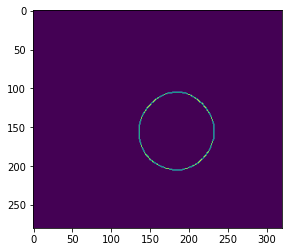

In [ ]:
#apply Canny edge detector on the masked image
maskimage = cv2.inRange(blur_img_1, 0, 70)
output = cv2.bitwise_and(blur_img_1, maskimage)
edged = cv2.Canny(output, 100, 220)
plt.imshow(edged)


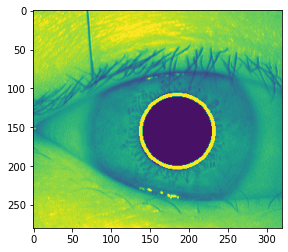

In [ ]:
# Apply Hough transform to find potential boundaries of pupil
circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 10, 100)
#define the center of the pupil
a = (crop_center_x,crop_center_y)
out = blur_img_1.copy()
min_dst=math.inf
for i in circles[0]:
#find the circle whose center is closest to the approx center found above
    b=(i[0],i[1])
    dst = distance.euclidean(a, b)
    if dst<min_dst:
      min_dst=dst
      k=i

#draw the inner boundary

localized_img_1 = cv2.circle(col_img_1, (int(k[0]), int(k[1])), int(k[2]), (255, 0, 0), 3)
plt.imshow(localized_img_1)


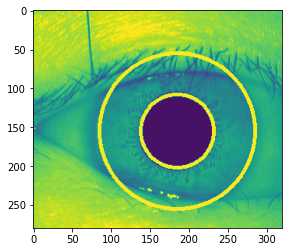

In [ ]:
pupil=circles[0][0]
radius_pupil = int(k[2])

#draw the outer boundary, which is approximately found to be at a distance 53 from the inner boundary
localized_img_1=cv2.circle(col_img_1, (int(k[0]), int(k[1])), radius_pupil+53, (255, 0, 0), 3)
plt.imshow(localized_img_1)


In [ ]:
centers = [k[0],k[1],k[2]]
centers


[185.0, 155.0, 47.0]

In [ ]:
# IRIS normalization

#load pupil centers and radius of inner circles
center_x = centers[0]
center_y = centers[1]
radius_pupil=int(centers[2])
center_x

185.0

In [ ]:
center_y

155.0

In [ ]:
radius_pupil


47

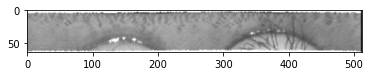

In [ ]:
iris_radius = 53   # width of space between inner and outer boundary

#define equally spaced interval to iterate over
im= localized_img_1
nsamples = 360
samples = np.linspace(0,2*np.pi, nsamples)[:-1]
polar = np.zeros((iris_radius, nsamples))
for r in range(iris_radius):
  for theta in samples:
    x = (r+radius_pupil)*np.cos(theta)+center_x
    y = (r+radius_pupil)*np.sin(theta)+center_y
    x=int(x)
    y=int(y)
    try:
       #convert coordinates
       polar[r][int((theta*nsamples)/(2*np.pi))] = im[y][x]
    except IndexError: #ignores values which lie out of bounds
        pass
    continue
normalized = cv2.resize(polar,(512,64))
plt.imshow(normalized)
plt.imshow(normalized, cmap = plt.cm.gray)

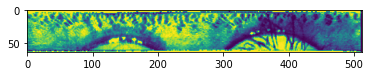

In [ ]:
# Image enhancement
enhanced=[]
for res in normalized:
    res = res.astype(np.uint8)
    im=cv2.equalizeHist(res)
    enhanced.append(im)
plt.imshow(np.squeeze(enhanced))


In [ ]:
# feature extraction
def m(x ,y, f):
    val = np.cos(2*np.pi*f*math.sqrt(x **2 + y**2))
    return val
#spatial filter as defined in paper
def gabor(x, y, dx, dy, f):
    gb = (1/(2*math.pi*dx*dy))*np.exp(-0.5*(x**2 / dx**2 + y**2 / dy**2)) * m(x, y, f)
    return gb

#function to calculate spatial filter over 8x8 blocks
def spatial(f,dx,dy):
    sfilter=np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            sfilter[i,j]=gabor((-4+j),(-4+i),dx,dy,f)
    return sfilter

def get_vec(convolvedtrain1,convolvedtrain2):
    feature_vec=[]
    for i in range(6):
            for j in range(64):
                #Run 8 by 8 filtered block iteratively over the entire image
                start_height = i*8
                end_height = start_height+8
                start_wid = j*8
                end_wid = start_wid+8
                grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
                grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]
                absolute = np.absolute(grid1)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

                # Channel 2
                absolute = np.absolute(grid2)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

    return feature_vec
con1=[]
con2=[]
#get spatial filters
filter1=spatial(0.67,3,1.5)
filter2=spatial(0.67,4,1.5)
feature_vector=[]
for i in range(len(enhanced)):
    img=enhanced[i]
    #define a 48x512 region over which the filters are applied
    img_roi=img[:48,:]

    filtered1=scipy.signal.convolve2d(img_roi,filter1,mode='same')
    filtered2=scipy.signal.convolve2d(img_roi,filter2,mode='same')

    con1.append(filtered1)
    con2.append(filtered2)
    fv=get_vec(filtered1,filtered2)
    feature_vector.append(fv)

In [ ]:
feature_vector

[[3.3783299550617647,
  0.9500928124841155,
  2.596086125067025,
  0.7301012040935544,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  n

# **Conclusion:**
We have successfully learnt about and implemented Iris Recognition in the above the code. The entire process is divided into 4 main steps: Acquisition, Segmentation, Normalization and Encoding/Matching. The first approach used the snake or GAC method for segmentation, whereas the second approach used integro-diiferential method. The final output obtained after the encoding stage was a feature vector containing numerical representation of the information extracted from the iris image used.
